In [ ]:
pip install numpy --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install setfit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 48.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 60.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 

In [ ]:
from sentence_transformers.losses import CosineSimilarityLoss
from setfit import SetFitModel, SetFitTrainer

In [ ]:
import os
import shutil
import json
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from nltk.tokenize import TweetTokenizer
from datasets import load_dataset

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_path = "/content/drive/MyDrive/ALC/subtask3/train_text.json"
labels_path = "/content/drive/MyDrive/ALC/subtask3/train_truth.json"

In [ ]:
# Load the data from the JSON file
with open(train_path, "r") as f:
  data = [json.loads(line.strip()) for line in f.readlines()]


with open(labels_path, "r") as f:
  data_labels = [json.loads(line.strip()) for line in f.readlines()]


In [ ]:
train = []
for author in data:
  muestra = []
  for tweet in author['texts']:
    muestra.append(tweet['text'])
  train.append(muestra)

labels = [author['class'] for author in data_labels]

In [ ]:
class_names = ['subjective opinion','financial information','advertising','announcement']
label_map = {label: i for i, label in enumerate(class_names)}
inv_label_map = {v: k for k, v in label_map.items()}
labels = np.array([label_map[label] for label in labels])

In [ ]:
labels_tensor = torch.tensor(labels)
labels = torch.nn.functional.one_hot(labels_tensor)

In [ ]:
X_train, y_train = train, labels

In [ ]:
len(y_train)

256

In [ ]:
def tokenize_twitter(data):
  tokenizer=TweetTokenizer(preserve_case = False,reduce_len = False)
  tok_tweets = []

  for user in data:
    n_tw = []
    for tweet in user:
      n_tw.append(' '.join(tokenizer.tokenize(tweet)))
    tok_tweets.append(' '.join(n_tw))
  return tok_tweets

In [ ]:
X_train=tokenize_twitter(X_train)

In [ ]:
print(X_train)
print(y_train)

['chevron price target raised to $ 160 from $ 150 at truist $ cvx', '@dougboneparth @ppearlman $ bal ends the day up 0.8 %', '#axs ( update ) running in + 39 % profit as expected 📈 📈 📈 #axsusdt $ axs #usdt https://t.co/70jd0thk9m', "great to see @qidaoprotocol that started on @0xpolygon grow to be a major stablecoin player ! having liquidity on several chains , it's a perfect fit for aave v3 . vote now with $ aave to give it wider acceptance fam ! 🙏🏼 https://t.co/aQsOjpUtgU", "what are we saying about $ fxs ? i'll ignore the coming snapshot for the airdrop and i will wait for price to reach lower before i spot buy some frax . imo this snapshot is only the driver for the price to have a short-term rally before falling brutally . expect a hard selloff . https://t.co/AkradbARhu", 'retweet if you believe huge $ doge pump coming soon ! 🔥 @elonmusk 👀', 'opera browser now supports handshake domains giving millions access to web 3 and the decentralized internet . make sure you own your online 

In [ ]:
num_classes = 4

# Convert the list of tensors into a 2D numpy array
labels_array = np.array([label.numpy() for label in y_train])

# Sum the elements of each column to get the number of samples per class
num_samples_per_class = np.sum(labels_array, axis=0)

# Convert the result to a list
num_samples_per_class_list = num_samples_per_class.tolist()

# Check that the number of classes is equal to the length of the list
assert len(num_samples_per_class_list) == num_classes

print(num_samples_per_class_list)

[64, 64, 64, 64]


In [ ]:
from datasets import DatasetDict, Dataset

data_dict = {
    "idx": range(len(X_train)),
    "sentence": X_train,
    "label": y_train
}

train_dataset = Dataset.from_dict(data_dict)

dataset_dict = DatasetDict({
    "train": train_dataset
})

In [ ]:
train_dataset = dataset_dict['train']

In [ ]:
train_dataset[3]

{'idx': 3,
 'sentence': "great to see @qidaoprotocol that started on @0xpolygon grow to be a major stablecoin player ! having liquidity on several chains , it's a perfect fit for aave v3 . vote now with $ aave to give it wider acceptance fam ! 🙏🏼 https://t.co/aQsOjpUtgU",
 'label': [1, 0, 0, 0]}

In [ ]:
model_id= "sentence-transformers/all-mpnet-base-v2"
model= SetFitModel.from_pretrained(model_id, multi_target_strategy="one-vs-rest")

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [ ]:
trainer = SetFitTrainer(
    model=model,
    train_dataset=train_dataset,
    loss_class=CosineSimilarityLoss,
    batch_size = 8,
    metric="f1",
    metric_kwargs={"average": "macro"},
    num_iterations=50,
    num_epochs=3,
    column_mapping={"sentence": "text", "label": "label"}
)

In [ ]:
trainer.train()

Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/50 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 25600
  Num epochs = 3
  Total optimization steps = 9600
  Total train batch size = 8


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3200 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3200 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3200 [00:00<?, ?it/s]

In [ ]:
from sentence_transformers import SentenceTransformer
model._save_pretrained("/content/drive/MyDrive/ALC/subtask3/finalSetFit/")

In [ ]:
saved_model = SetFitModel._from_pretrained("/content/drive/MyDrive/ALC/subtask3/finalSetFit")

In [ ]:
train_embed=[]
for author in X_train:
  user_embed=saved_model.model_body.encode(author, convert_to_numpy=True)
  train_embed.append(user_embed)

In [ ]:
numpy_labels = [tensor.numpy() for tensor in y_train]

[1, 1, 1, 0, 0, 0, 2, 0, 0, 1, 3, 2, 2, 0, 1, 0, 3, 2, 1, 2, 3, 2, 3, 3, 0, 3, 3, 3, 2, 0, 2, 0, 0, 2, 0, 2, 0, 2, 1, 1, 1, 0, 0, 0, 1, 2, 0, 3, 3, 1, 2, 1, 1, 1, 1, 0, 3, 2, 0, 3, 3, 3, 2, 1, 3, 3, 2, 0, 0, 2, 3, 3, 3, 0, 0, 2, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 2, 1, 0, 1, 3, 2, 2, 1, 0, 1, 0, 0, 2, 3, 1, 3, 1, 0, 2, 2, 2, 1, 3, 1, 3, 2, 0, 1, 1, 2, 2, 0, 1, 1, 2, 0, 0, 0, 3, 1, 2, 0, 0, 0, 2, 1, 2, 3, 3, 1, 0, 0, 1, 3, 0, 2, 2, 2, 1, 2, 0, 0, 1, 2, 1, 0, 1, 3, 2, 1, 0, 2, 1, 0, 3, 1, 0, 2, 1, 1, 1, 1, 1, 0, 2, 0, 1, 2, 2, 3, 2, 2, 3, 1, 3, 2, 3, 3, 1, 3, 0, 1, 0, 0, 2, 2, 1, 3, 0, 1, 2, 1, 1, 3, 0, 2, 1, 3, 3, 0, 1, 3, 3, 2, 2, 1, 3, 3, 2, 2, 1, 1, 3, 2, 3, 2, 0, 0, 2, 3, 3, 0, 0, 3, 2, 2, 0, 1, 1, 3, 0, 0, 2, 3, 1, 3, 1, 1, 3, 3, 0, 0, 2, 3, 2, 1, 0, 1, 0, 3]
{0, 1, 2, 3}


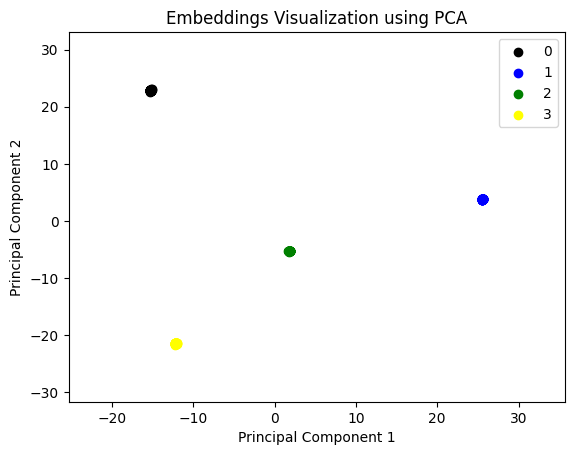

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assuming 'embeddings' is the list of embeddings
# Assuming 'labels' is the list of corresponding labels

# Standardize the embeddings
embeddings_standardized = (train_embed - np.mean(train_embed, axis=0)) / np.std(train_embed, axis=0)

# Apply PCA
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings_standardized)
y_train_np = [tensor.numpy().tolist() for tensor in y_train]
y_train_np = np.argmax(y_train_np, axis=1).tolist()
print(y_train_np)
# Plot the embeddings with colors based on labels
unique_labels = set(y_train_np)
print(unique_labels)
label_colors = ['black', 'blue', 'green', 'yellow','red']  # Define colors for each unique label
for label, color in zip(unique_labels, label_colors):
    indices = [i for i, l in enumerate(y_train_np) if l == label]
    plt.scatter(embeddings_pca[indices, 0], embeddings_pca[indices, 1], c=color, label=label)


plt.xlim(embeddings_pca[:, 0].min() -10, embeddings_pca[:, 0].max() + 10)
plt.ylim(embeddings_pca[:, 1].min() -10, embeddings_pca[:, 1].max() +10 )
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Embeddings Visualization using PCA')
plt.legend()
plt.show()

In [ ]:
preds = saved_model(X_train)

In [ ]:
prob = saved_model.predict_proba(X_train)

In [ ]:
preds[0]

tensor([0, 1, 0, 0])

In [ ]:
prob[0]

tensor([0.0242, 0.9271, 0.0243, 0.0244], dtype=torch.float64)